#### Beat detection

In [1]:
import pandas as pd
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

current_directory = os.getcwd()
print(f"\nCurrent working directory: {current_directory}\n")

path_data = "Datasets/groove"
filename = os.path.join(path_data, "info.csv")

data = pd.read_csv(filename, encoding="latin-1")
data.head()


Current working directory: /Users/vinni/Desktop/Code/Audio Data Science/StyleExtraction



,drummer,session,id,style,bpm,beat_type,time_signature,midi_filename,audio_filename,duration,split
0,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,138,beat,4-4,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,27.872308,test
1,drummer1,drummer1/eval_session,drummer1/eval_session/10,soul/groove10,102,beat,4-4,drummer1/eval_session/10_soul-groove10_102_bea...,drummer1/eval_session/10_soul-groove10_102_bea...,37.691158,test
2,drummer1,drummer1/eval_session,drummer1/eval_session/2,funk/groove2,105,beat,4-4,drummer1/eval_session/2_funk-groove2_105_beat_...,drummer1/eval_session/2_funk-groove2_105_beat_...,36.351218,test
3,drummer1,drummer1/eval_session,drummer1/eval_session/3,soul/groove3,86,beat,4-4,drummer1/eval_session/3_soul-groove3_86_beat_4...,drummer1/eval_session/3_soul-groove3_86_beat_4...,44.716543,test
4,drummer1,drummer1/eval_session,drummer1/eval_session/4,soul/groove4,80,beat,4-4,drummer1/eval_session/4_soul-groove4_80_beat_4...,drummer1/eval_session/4_soul-groove4_80_beat_4...,47.987500,test


### Feature Extraktion
Für das Projekt relevante Descriptoren könnten sein:
- Onset erkennung (Zeitlich) -> __rhytmische Merkmale__
    - Onset Function
        - Wahrscheinlichkeit für jeden Zeitpunkt (Frame), dass ein Ereigniss (Onset) stattfindet
    - Spectral Flux 
        - misst die Veränderung im Spektrum zwischen aufeinanderfolgenden Frames (wie Stark ist die Veränderung der Frames)
        - Onset erkennung
- Spektrale Desktiptoren/ Dynamik des Signals -> __spektrale Merkmale__
    - MFCCs 
        - repräsentieren die Kurzzeit-Leistungsdichte eines Audiosignals, basierend auf einer Mel-Skala-Frequenzachse 
        - gut für Klangfarben und Spektralcharakteristika der Loops
    - Spectral Contrast
        - Spectral Contrast misst den Unterschied zwischen Spitzen- und Talpegeln im Spektrum
        - gut um die Dynamik der Loops zu erfassen
    - Tonnetz 
        - harmonische und rythmische Struktur des Loops
        - Zwar eher im harmonischen Kontext aber gibt trotzdem auskunft über die relative Häufigkeit und die Verteilung von harmonischen und rythmischen Elementen
    - RMS Energy (Root Mean Square Energy)
        - durchschnittliche Leistung des Audiosignals über einen Zeitraum
    - Spectral Centroid
        - Schwerpunkt des Frequenzspektrums (Wie hoch ist derf Anteil Tieffrequenter Signale)
    - Spectral Roll-off
    - 


##### Rhytmische Merkmale

Onset Funktion 

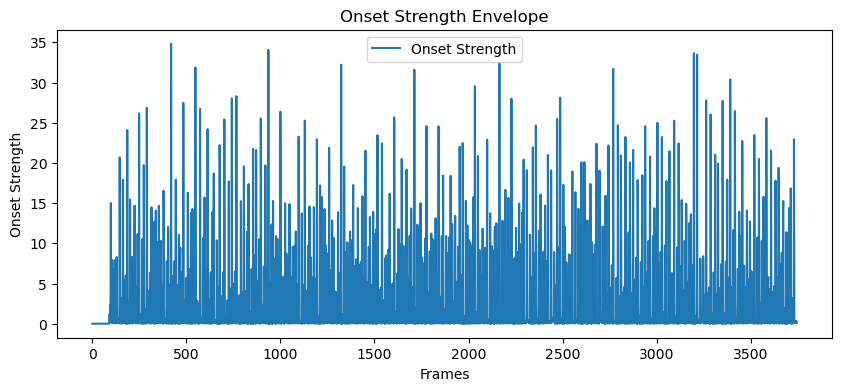

2.3283556

In [16]:
audio_path = "Datasets/groove/drummer1/session1/1_funk_80_beat_4-4.wav"
#Audio laden (als numpy-Arrray (y)und die samplerate (sr))
y, sr = librosa.load(audio_path)
#Onset berechnen (Stärke der Onsets im Zeitverlauf)
onset_env = librosa.onset.onset_strength(y=y, sr=sr)
plt.figure(figsize=(10, 4))
plt.plot(onset_env, label='Onset Strength')
plt.xlabel('Frames') #basieren auf dem Zeitramen der pro Frame gesetzt wird
plt.ylabel('Onset Strength')
plt.title('Onset Strength Envelope')
plt.legend(loc='best')
plt.show()
pd.Series(onset_env).mean()

Spectral Flux

In [15]:
spectral_flux = librosa.onset.onset_strength(y=y, sr=sr)
print(spectral_flux)

[0.         0.         0.         ... 0.31767222 0.2477682  0.10720779]


##### Spektrale Merkmale

MFCCs

In [4]:
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

Spectral Contrast

In [5]:
contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

Tonnetz (relevanz prüfen)

In [6]:
tonnetz = librosa.feature.tonnetz(y=y, sr=sr)

RMS Energy (Root Mean Square Energy) (Relevanz prüfen wegen unterscheidlicher RMS der zu klassifizierenden Audiosamples unabhängig vom Genre -> Normalisiert)

In [7]:
rms = librosa.feature.rms(y=y)

Spectral Centroid

In [8]:
spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)

### Feature-Skalierung/ Normlisrung
- scaler.fit(features) berechnet den Mittelwert und die Standardabweichung jedes Features basierend auf den Trainingsdaten.
- scaler.transform(features) wendet die berechneten Skalierungsparameter (Mittelwert und Standardabweichung) an, um jedes Feature zu standardisieren.
- scaler.fit_transform(features) kombiniert diese beiden Schritte: Es passt den Scaler an die Daten an und transformiert die Daten in einem Schritt.

1. Features in ein Feature MaArraytrix schreiben

In [9]:
features = np.vstack((onset_env, spectral_flux, mfcc, spectral_centroid, tonnetz, rms, contrast))

2. Transponieren der Features
-  jede Zeile enspricht einem Frame entspricht und jede Spalte ein Feature


In [10]:
features = features.T 

3. Initialisieren des Scalers (MW =1 , SD=0)
- Skaleneffekte elliminieren

In [11]:
scaler = StandardScaler()

Anpassen und Transformieren der Features:

In [12]:
features = scaler.fit_transform(features)